In [1]:
import pandas as pd
from google.colab import drive
drive.mount('/content/gdrive')
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
data = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/ML HW2/seeds.csv')

data.head()

Area  Perimeter  Compactness  Kernel.Length  Kernel.Width  \
0  15.26      14.84       0.8710          5.763         3.312   
1  14.88      14.57       0.8811          5.554         3.333   
2  14.29      14.09       0.9050          5.291         3.337   
3  13.84      13.94       0.8955          5.324         3.379   
4  16.14      14.99       0.9034          5.658         3.562   

   Asymmetry.Coeff  Kernel.Groove  Type  
0            2.221          5.220     1  
1            1.018          4.956     1  
2            2.699          4.825     1  
3            2.259          4.805     1  
4            1.355          5.175     1

## Part 1: EDA

Scatter Plot


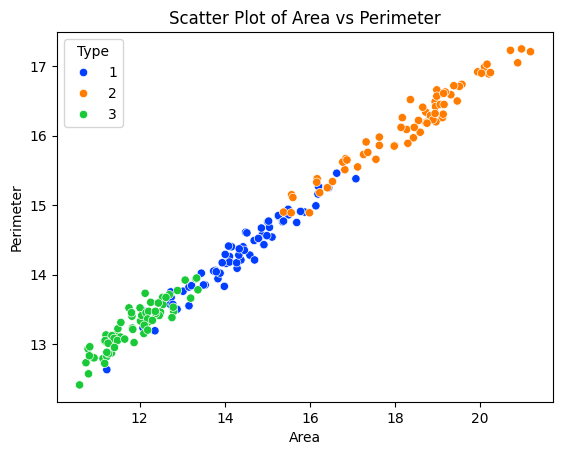

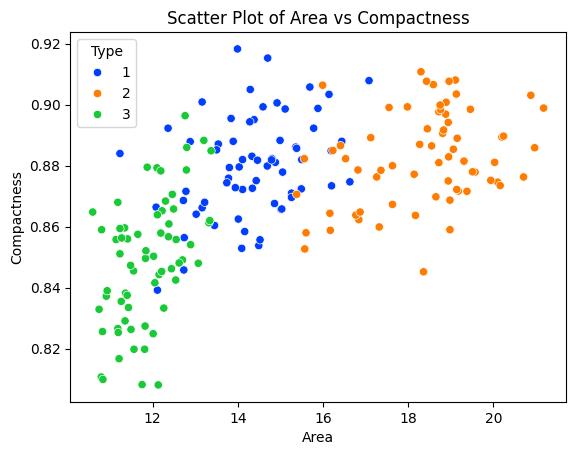

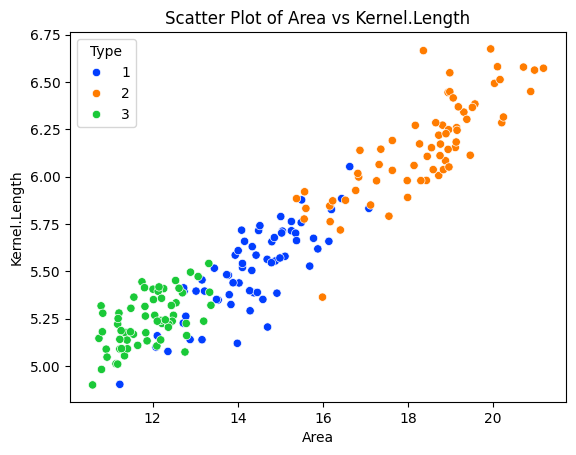

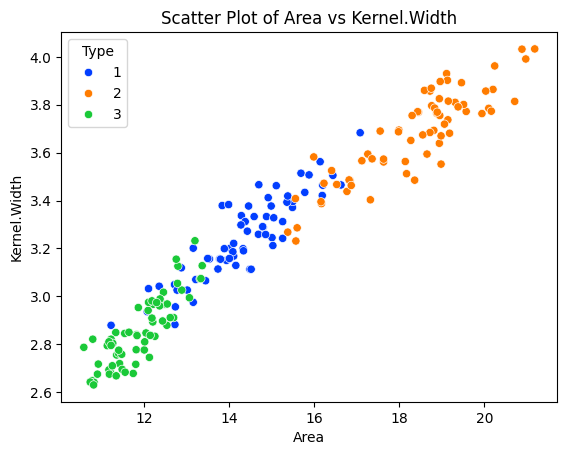

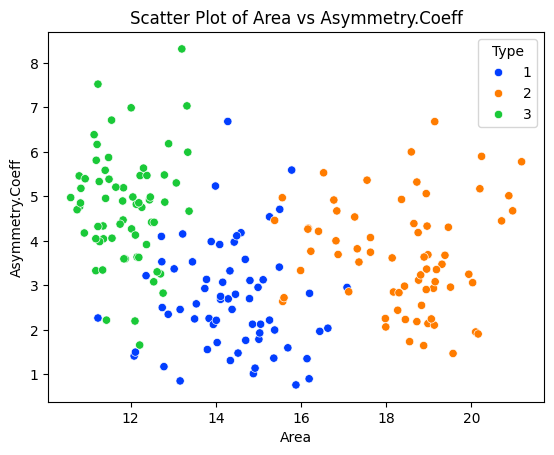

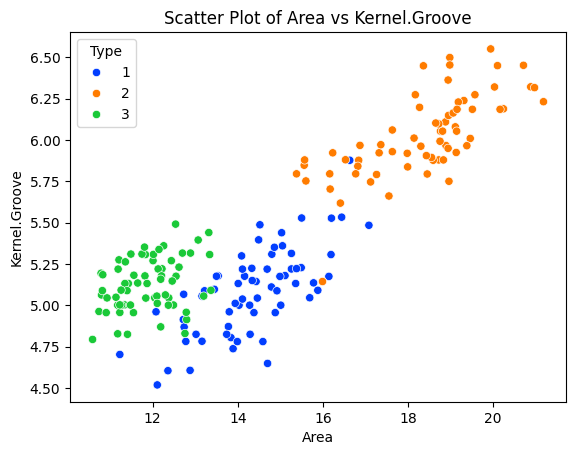

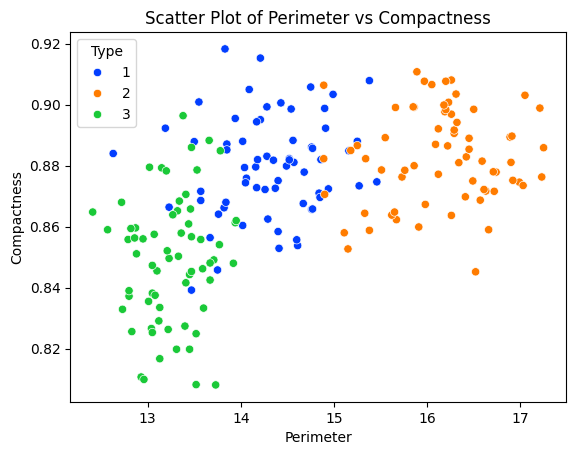

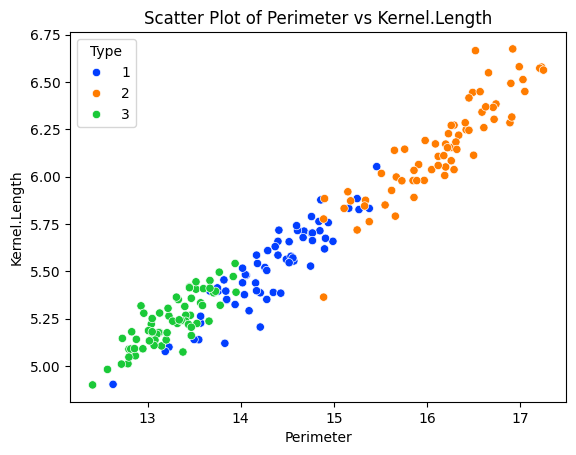

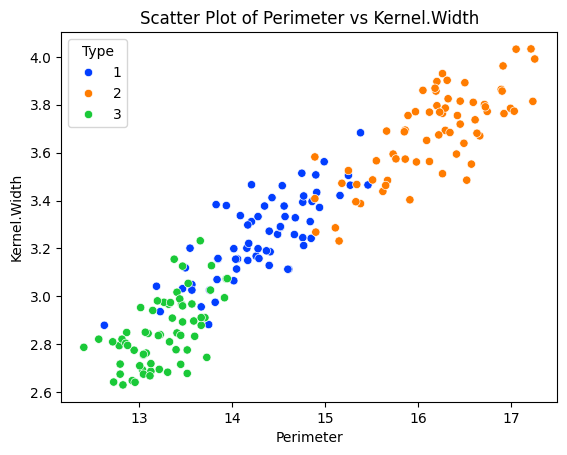

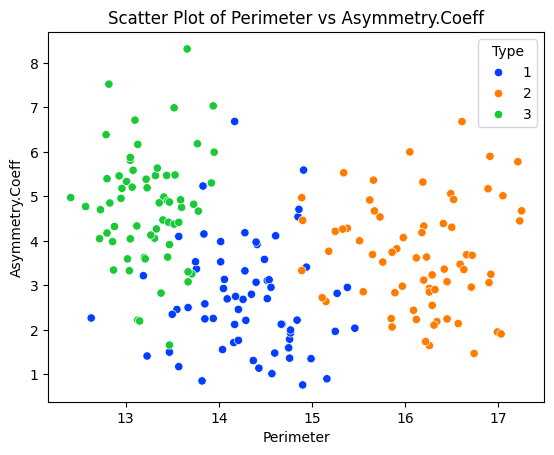

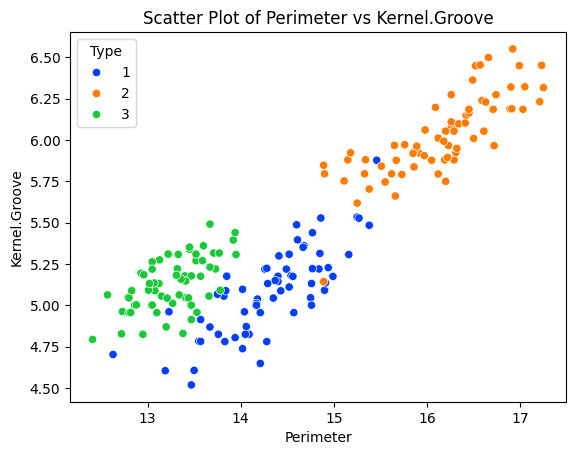

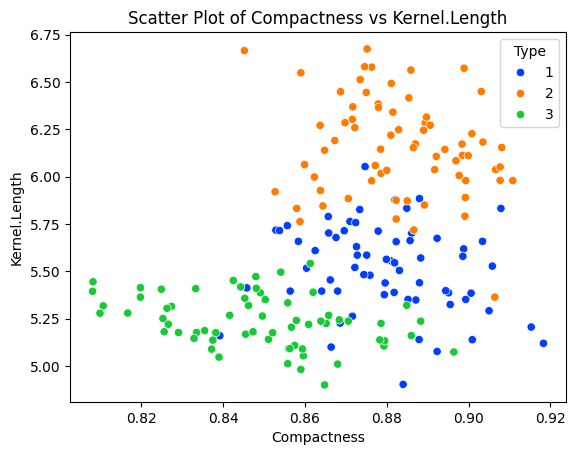

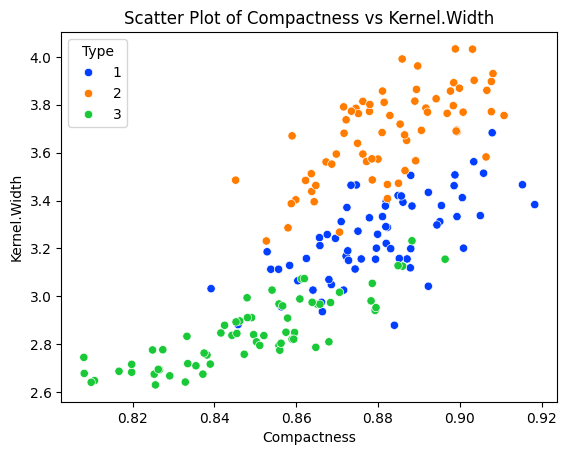

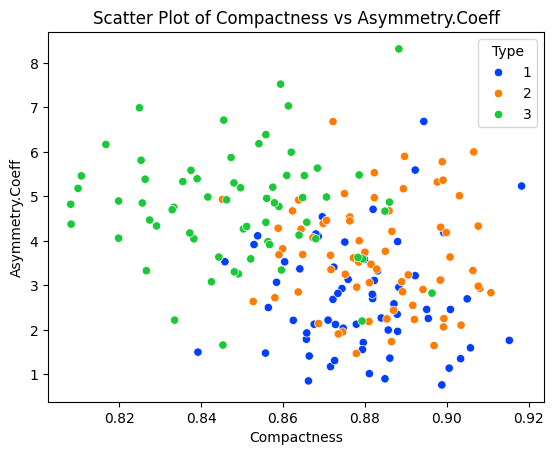

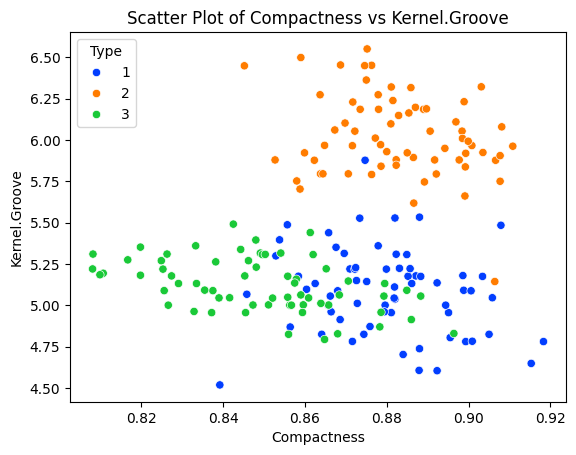

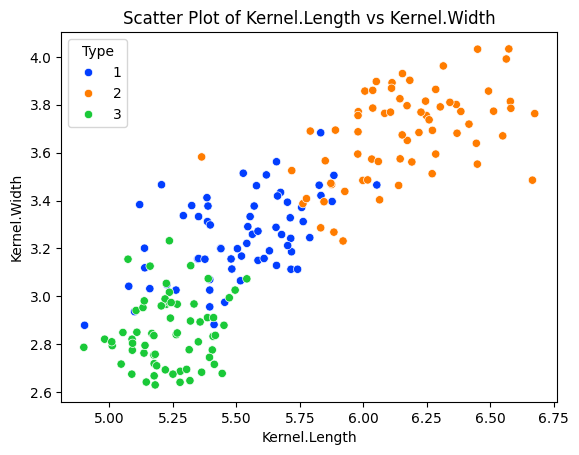

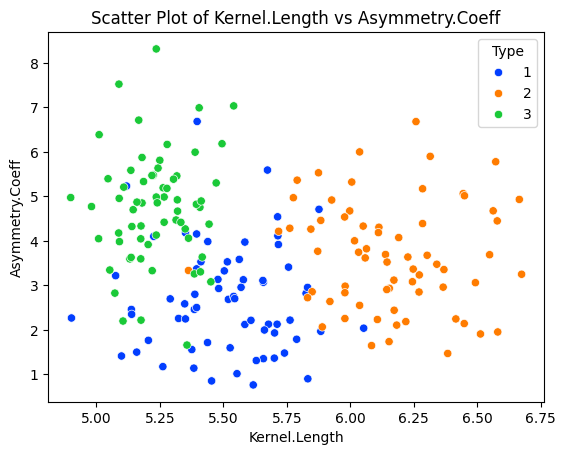

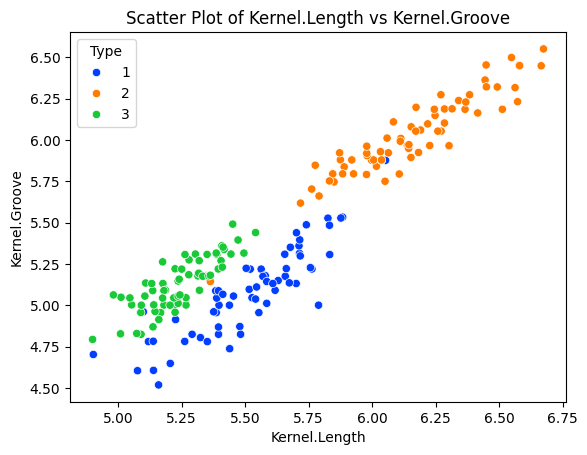

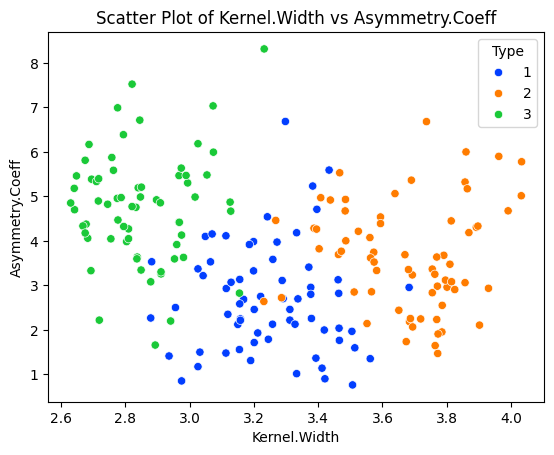

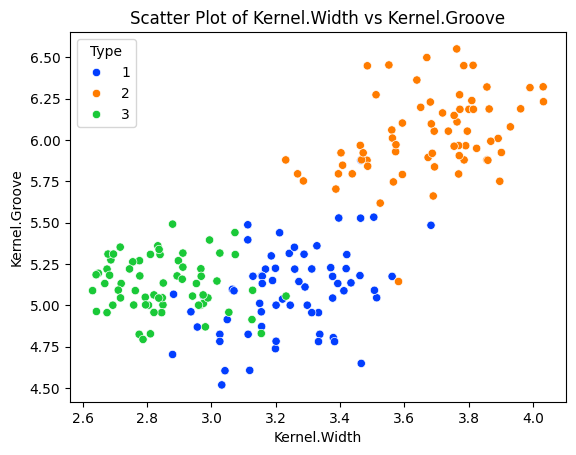

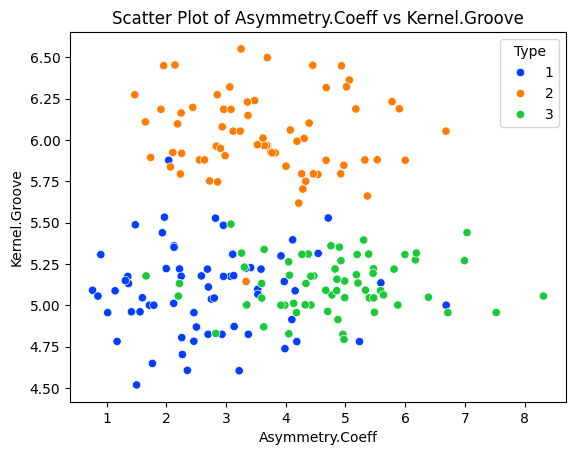

In [3]:
for i, feature1 in enumerate(data.columns[:-1]):
    for j, feature2 in enumerate(data.columns[i+1:-1]):
        sns.scatterplot(data=data, x=feature1, y=feature2, hue='Type', palette='bright')
        plt.title(f'Scatter Plot of {feature1} vs {feature2}')
        plt.show()

Histogram

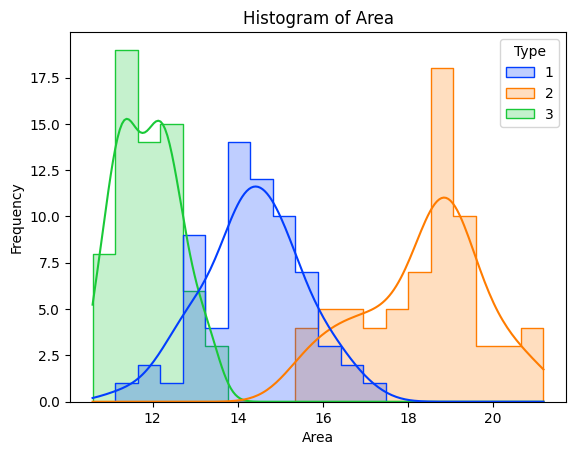

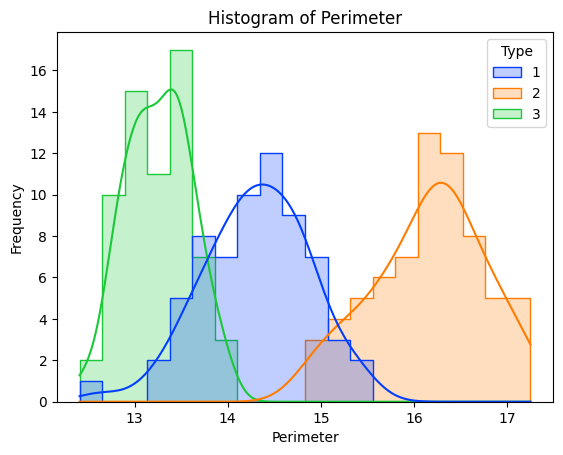

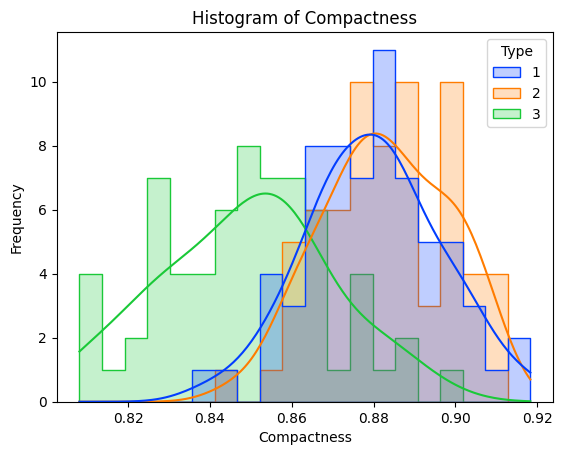

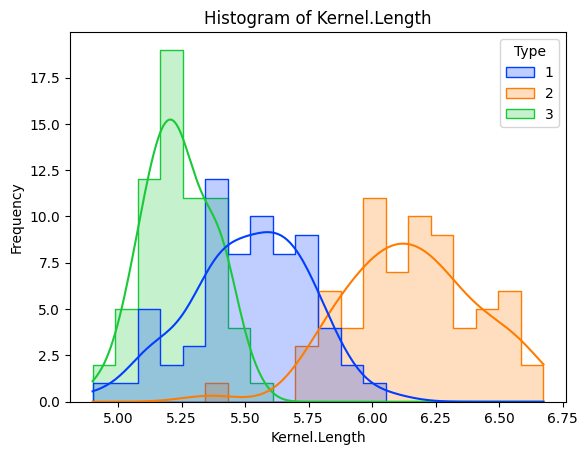

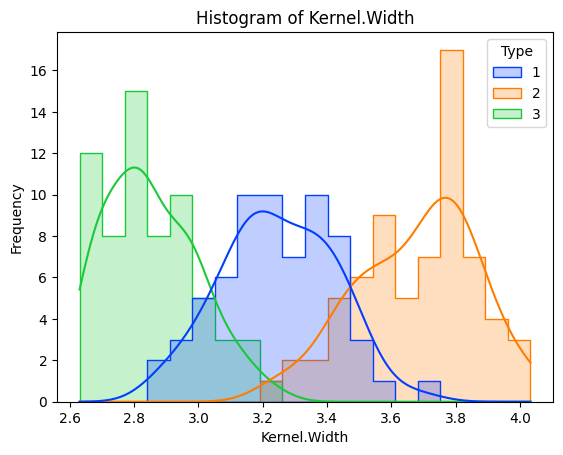

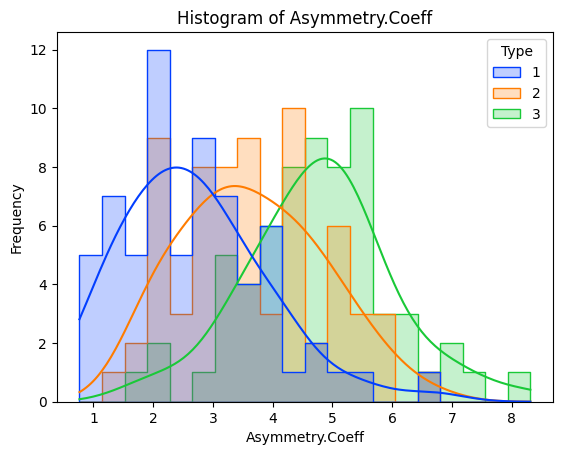

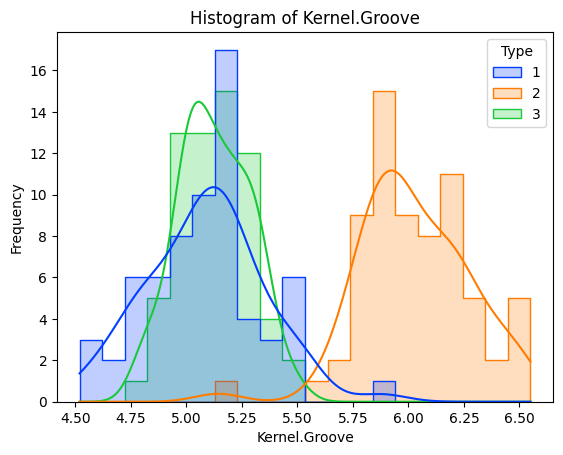

In [4]:
for i, feature in enumerate(data.columns[:-1]):
    sns.histplot(data=data, x=feature, hue="Type", element="step", palette='bright', bins=20, kde=True)
    plt.title(f'Histogram of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()

##Part 2 : Preprocessing & Normalization

In [5]:
#Checking for missing Values
missing_values_count = [0] * len(data.loc[0])
for row in data:
    for i, value in enumerate(row):
        if value is None or (isinstance(value, str) and value.strip() == ""):
            missing_values_count[i] += 1


print("Missing values per column:", missing_values_count)

Missing values per column: [0, 0, 0, 0, 0, 0, 0, 0]


In [6]:
# Min-Max Scaling
min_values = data.iloc[:, :-1].min()
max_values = data.iloc[:, :-1].max()
Scaled_data = (data.iloc[:, :-1] - min_values) / (max_values - min_values)

Scaled_data.head()

Area  Perimeter  Compactness  Kernel.Length  Kernel.Width  \
0  0.440982   0.502066     0.570780       0.486486      0.486101   
1  0.405099   0.446281     0.662432       0.368806      0.501069   
2  0.349386   0.347107     0.879310       0.220721      0.503920   
3  0.306893   0.316116     0.793103       0.239302      0.533856   
4  0.524079   0.533058     0.864791       0.427365      0.664291   

   Asymmetry.Coeff  Kernel.Groove  
0         0.192837       0.345150  
1         0.033497       0.215165  
2         0.256149       0.150665  
3         0.197870       0.140817  
4         0.078133       0.322994

In [7]:
#  Z scoreing
mean_values = Scaled_data.iloc[:, :].mean()
std_dev_values = Scaled_data.iloc[:, :].std()
Standard_data = (Scaled_data.iloc[:, :] - mean_values) / std_dev_values

In [8]:
Standard_data.head()

Area  Perimeter  Compactness  Kernel.Length  Kernel.Width  \
0  0.116870   0.186327     0.008124       0.270178      0.122825   
1 -0.013269  -0.019710     0.441229      -0.200974      0.178333   
2 -0.215325  -0.385998     1.466100      -0.793859      0.188906   
3 -0.369436  -0.500463     1.058724      -0.719467      0.299923   
4  0.418242   0.300792     1.397490       0.033475      0.783638   

   Asymmetry.Coeff  Kernel.Groove  
0        -1.004836      -0.407238  
1        -1.822590      -0.943041  
2        -0.679910      -1.208914  
3        -0.979005      -1.249505  
4        -1.593511      -0.498568

##Part3: Classification

##Split data

In [23]:
def split_data(x, y, ratio):

    data = np.column_stack((x, y))
    np.random.shuffle(data)
    split_idx = int(len(data) * ratio)

    x_train = data[:split_idx, :-1]
    y_train = data[:split_idx, -1]
    x_test = data[split_idx:, :-1]
    y_test = data[split_idx:, -1]

    return x_train, x_test, y_train, y_test


x = Standard_data.iloc[:,:].values
y = data.iloc[:, -1].values

x_train, x_test, y_train, y_test = split_data(x, y, 0.8)

print('Train set size:', len(x_train))
print('Test set size:', len(x_test))

Train set size: 159
Test set size: 40


##Logestic Regression

In [20]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def compute_cost(theta, X, y):
    m = y.size
    h = sigmoid(X.dot(theta))
    cost = -(1/m) * (np.dot(y, np.log(h)) + np.dot(1 - y, np.log(1 - h)))
    return cost

def gradient(theta, X, y):
    m = y.size
    h = sigmoid(X.dot(theta))
    grad = (1/m) * (X.T.dot(h - y))
    return grad

def gradient_descent(X, y, theta, alpha, num_iters):
    J_history = []
    for i in range(num_iters):
        theta -= alpha * gradient(theta, X, y)
        J_history.append(compute_cost(theta, X, y))
    return theta, J_history


##One-vs-All

In [21]:
def one_vs_all(X, y, num_labels, alpha, num_iters):
    m, n = X.shape
    all_theta = np.zeros((num_labels, n + 1))
    X = np.concatenate([np.ones((m, 1)), X], axis=1)

    for c in range(num_labels):
        initial_theta = np.zeros(n + 1)
        label = (y == c).astype(int)
        theta, _ = gradient_descent(X, label, initial_theta, alpha, num_iters)
        all_theta[c, :] = theta

    return all_theta

num_labels = len(np.unique(y_train))
alpha = 0.1
num_iters = 300

theta = one_vs_all(x_train, y_train, num_labels, alpha, num_iters)

## Prediction

In [24]:
def predict_one_vs_all(all_theta, X):
    m = X.shape[0]
    X = np.concatenate([np.ones((m, 1)), X], axis=1)  # Add intercept
    predictions = sigmoid(X.dot(all_theta.T))
    return np.argmax(predictions, axis=1)

def confusion_matrix(y_true, y_pred, num_classes):
    matrix = np.zeros((num_classes, num_classes))
    for i in range(num_classes):
        for j in range(num_classes):
            matrix[i, j] = np.sum((y_true == i) & (y_pred == j))
    return matrix

def compute_metrics(matrix):
    eps = 1e-10
    precision = np.diag(matrix) / (np.sum(matrix, axis=0) + eps)
    recall = np.diag(matrix) / (np.sum(matrix, axis=1) + eps)
    f1_score = 2 * (precision * recall) / (precision + recall + eps)
    accuracy = np.sum(np.diag(matrix)) / np.sum(matrix)
    return accuracy, precision, recall, f1_score

y_pred = predict_one_vs_all(theta, x_test)
num_classes = len(np.unique(y_train))
cm = confusion_matrix(y_test, y_pred, num_classes)

accuracy, precision, recall, f1_score = compute_metrics(cm)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)
print("Confusion Matrix:\n", cm)

Accuracy: 0.9583333333333334
Precision: [0.         1.         0.91666667]
Recall: [0.         0.92307692 1.        ]
F1 Score: [0.         0.96       0.95652174]
Confusion Matrix:
 [[ 0.  0.  0.]
 [ 0. 12.  1.]
 [ 0.  0. 11.]]


## Part4 : KNN

In [13]:
def euclidean_distance(x1, x2):
    return np.linalg.norm(x1 - x2, axis=1)

def knn_predict(x_train, y_train, x_test, k):
    predictions = []
    for test_instance in x_test:

        distances = euclidean_distance(x_train, test_instance)
        k_indices = np.argsort(distances)[:k]
        k_nearest_labels = y_train[k_indices]
        k_nearest_labels = k_nearest_labels.astype(int)
        prediction = np.bincount(k_nearest_labels).argmax()
        predictions.append(prediction)
    return np.array(predictions)

In [14]:
def compute_accuracy(y_true, y_pred):
    return np.sum(y_true == y_pred) / len(y_true)

def test_k_values(x_train, y_train, x_test, y_test, k_values):
    accuracies = []
    for k in k_values:
        y_pred = knn_predict(x_train, y_train, x_test, k)
        accuracy = compute_accuracy(y_test, y_pred)
        accuracies.append(accuracy)
    return accuracies


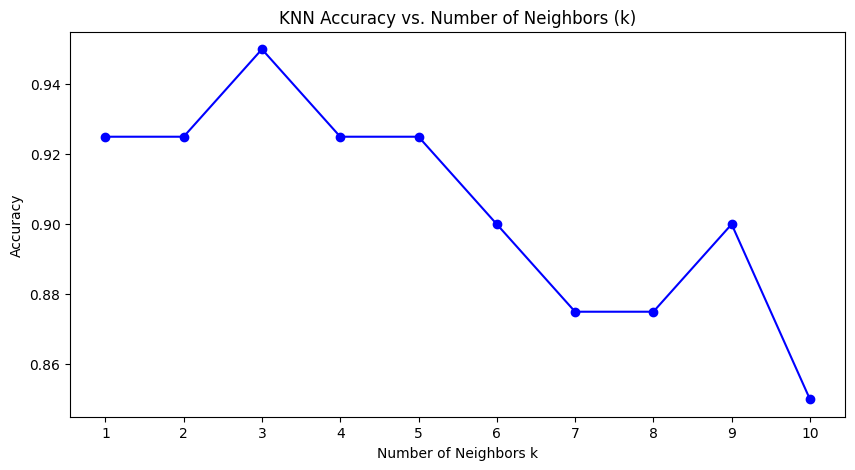

In [25]:
k_values = range(1, 11)
accuracies = test_k_values(x_train, y_train, x_test, y_test, k_values)

plt.figure(figsize=(10, 5))
plt.plot(k_values, accuracies, marker='o', linestyle='-', color='b')
plt.title('KNN Accuracy vs. Number of Neighbors (k)')
plt.xlabel('Number of Neighbors k')
plt.ylabel('Accuracy')
plt.xticks(k_values)
plt.show()